In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import iefc_2dm as iefc
from wfsc import utils

# import misc

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

# dm1_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm1.fits')
# dm2_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm2.fits')

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [3]:
cgi.__file__

'/home/u21/kianmilani/src/cgi-phasec-poppy/cgi_phasec_poppy/__init__.py'

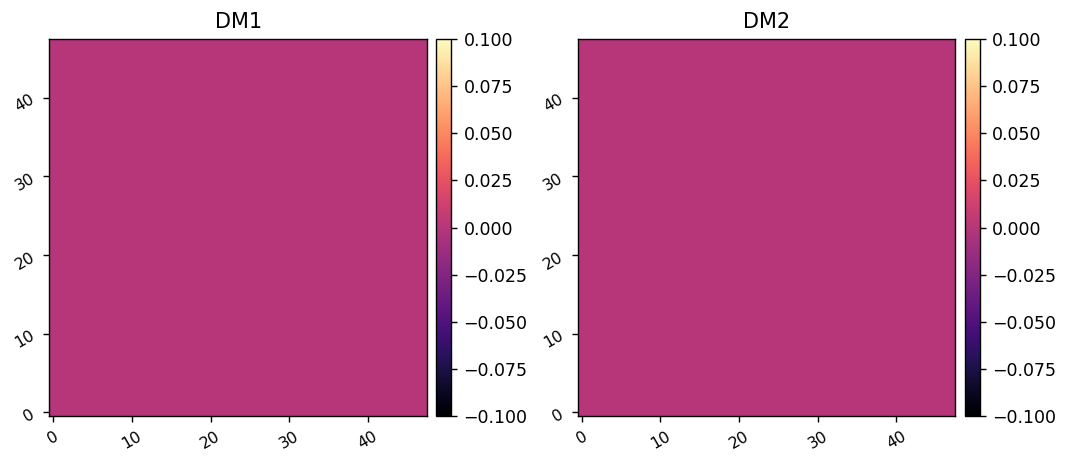

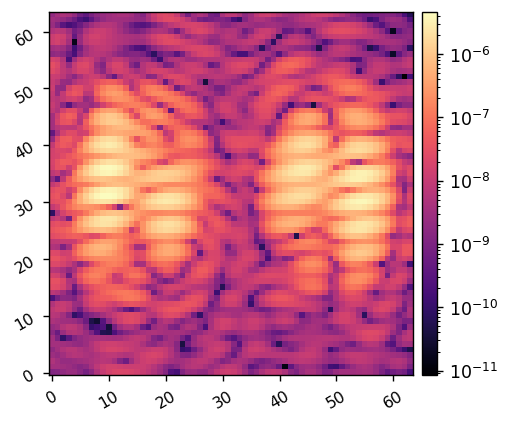

In [2]:
reload(cgi)
sys = cgi.CGI(cgi_mode='spc-spec', npsf=64,
              use_fpm=True,
              use_pupil_defocus=True, 
              polaxis=0,
              use_opds=True,
#               dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
sys.show_dms()

npsf = sys.npsf
Nact = sys.Nact

ref_psf = sys.snap()

misc.myimshow(ref_psf, lognorm=True)

# Create dark hole ROI to calibrate and control

816


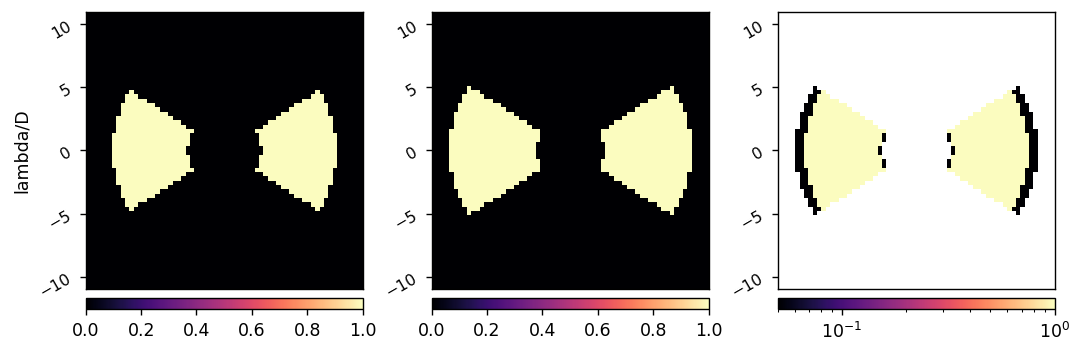

In [3]:
reload(utils)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * sys.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 9
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'side':'b'
}
dh_mask = utils.create_bowtie_mask(xf, yf, dh_params)

control_params = {
    'inner_radius' : iwa-0.3,
    'outer_radius' : owa+0.7,
    'side':'b'
}
control_mask = utils.create_bowtie_mask(xf, yf, control_params)

nmask = control_mask.sum()
print(nmask)

relative_weight = 0.95
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

misc.myimshow3(dh_mask,
               control_mask, 
               weights,
               lognorm3=True,
               pxscl1=sys.psf_pixelscale_lamD, pxscl2=sys.psf_pixelscale_lamD, pxscl3=sys.psf_pixelscale_lamD)

# Create probe and fourier modes

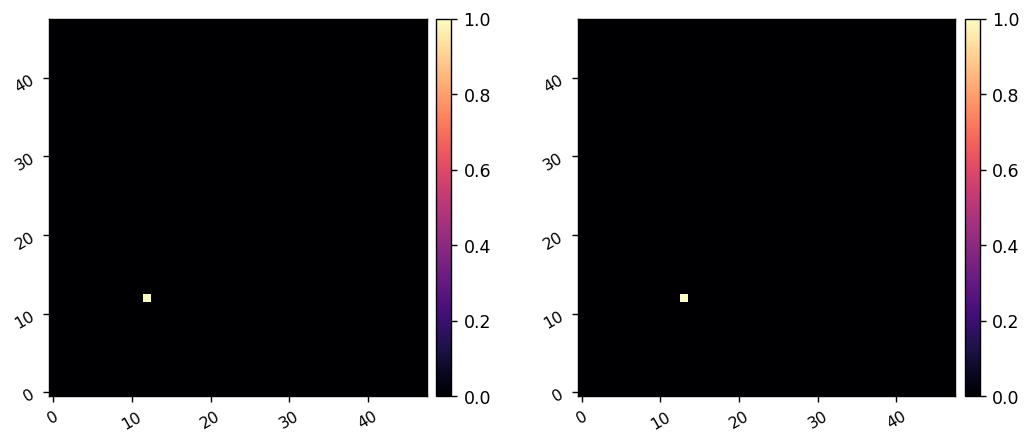

Creating Fourier modes:  (64, 64)
Calibration modes required: 224


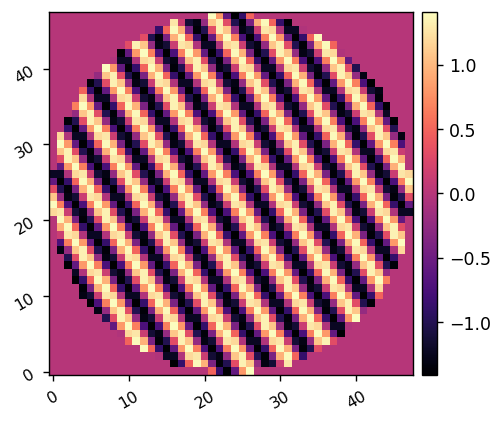

In [4]:
reload(iefc)
probe_modes = iefc.create_probe_poke_modes(Nact, 
                                           xinds=[Nact//4, Nact//4+1],
                                           yinds=[Nact//4, Nact//4], 
                                           display=True)

calibration_modes, fx, fy = iefc.create_fourier_modes(xfp, 
                                                      control_mask.reshape((npsf,npsf)), 
                                                      Nact, 
                                                      circular_mask=False)
calibration_modes[:] *= sys.dm_mask.flatten()

nmodes = calibration_modes.shape[0]
print('Calibration modes required: {:d}'.format(nmodes))
misc.myimshow(calibration_modes[0].reshape(Nact,Nact))

calibration_amplitude = 0.006 * sys.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * sys.wavelength_c.to(u.m).value

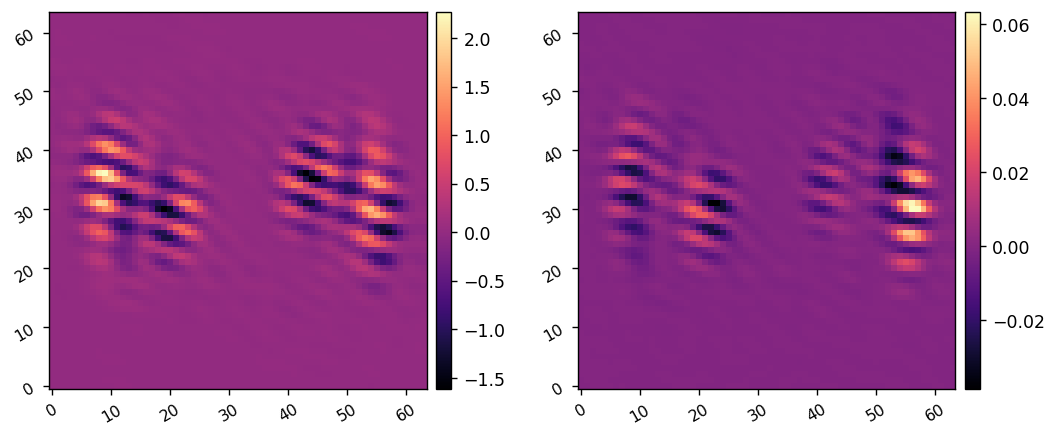

In [5]:
reload(iefc)
sys.reset_dms()
differential_images, single_images = iefc.take_measurement(sys, 
                                                           probe_modes, probe_amplitude, 
                                                           return_all=True, display=True)

# Calibrate IEFC (or load in previous calibration data)

In [11]:
reload(iefc)
response_cube, calibration_cube = iefc.calibrate(sys, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, calibration_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 224 in 5.796s
	Calibrated mode 2 / 224 in 11.775s
Calibration interrupted.
Calibration complete.


In [6]:
fname = 'spc_spec_2dm_both_3to9'
iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

In [29]:
misc.save_pickle(iefc_dir/'response-data'/fname, response_cube)
misc.save_pickle(iefc_dir/'calibration-data'/fname, calibration_cube)

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/spc_wide_2dm_full_6to10
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/spc_wide_2dm_full_6to10


In [7]:
response_cube = misc.load_pickle(iefc_dir/'response-data'/fname)
calibration_cube = misc.load_pickle(iefc_dir/'calibration-data'/fname)

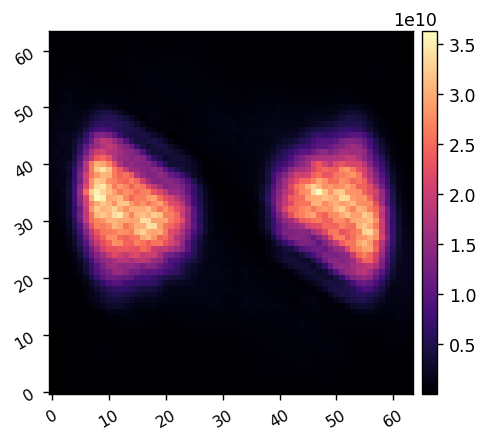

In [8]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64))

# Create control matrix

In [10]:
reload(iefc)
# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

control_matrix = iefc.construct_control_matrix(response_cube, 
                                               weights.flatten(), 
                                               rcond1=5e-3,
                                               rcond2=5e-3,
                                               WLS=True,
                                               nprobes=probe_modes.shape[0],
                                               pca_modes=None)

Using Weighted Least Squares 


In [10]:
control_matrix.shape

(5376, 26680)

# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 20


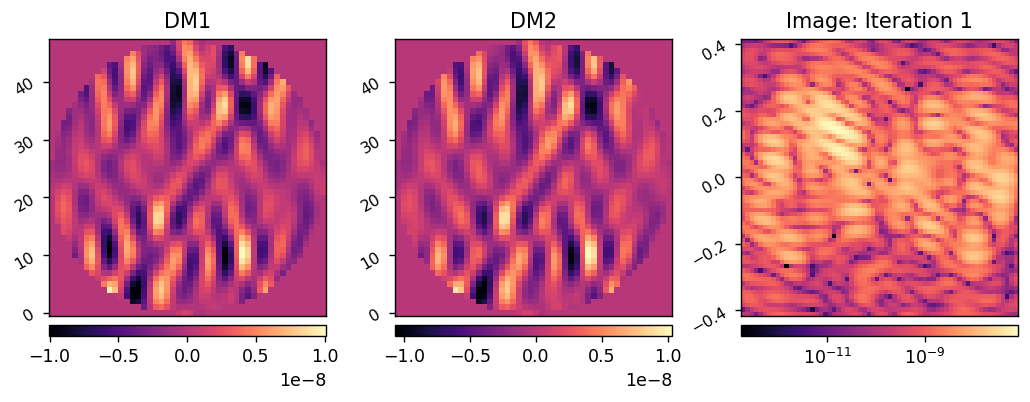

	Closed-loop iteration 2 / 20


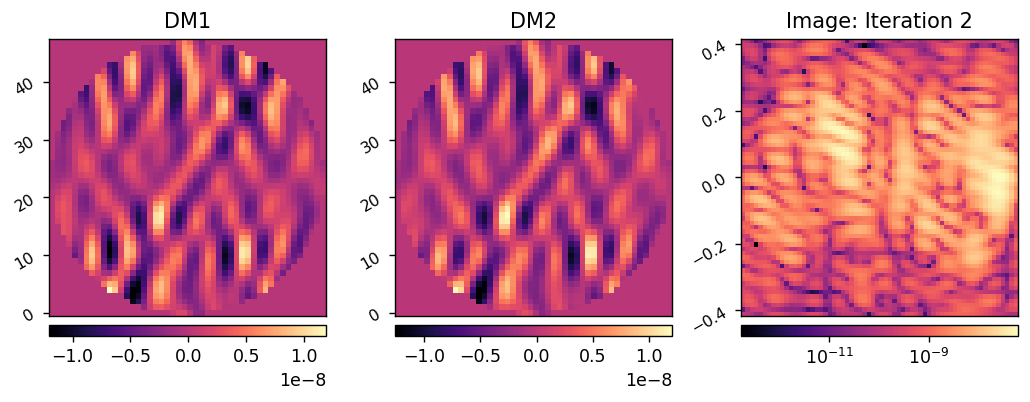

	Closed-loop iteration 3 / 20


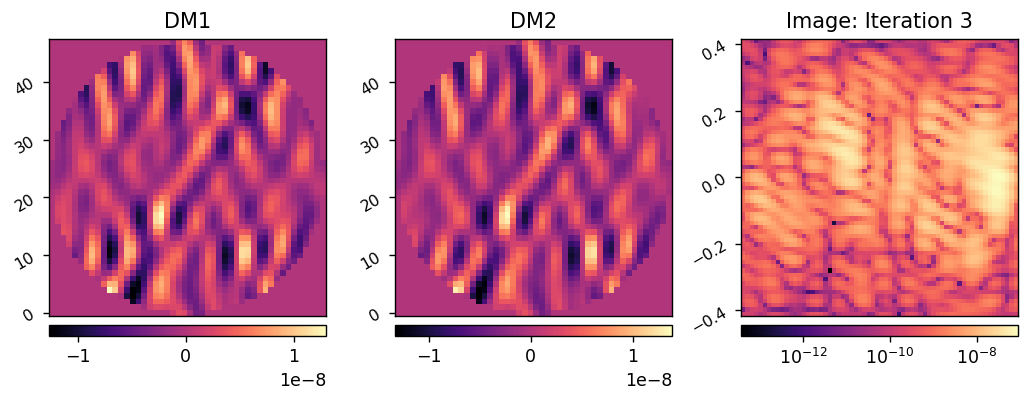

	Closed-loop iteration 4 / 20


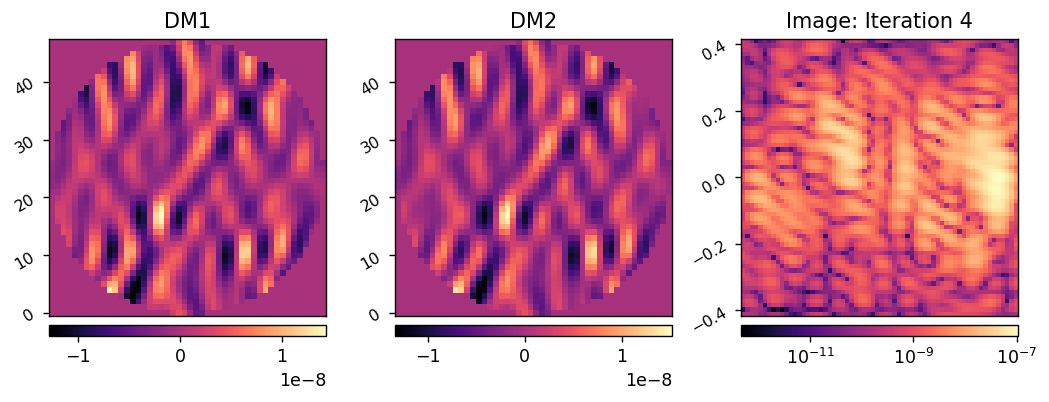

	Closed-loop iteration 5 / 20


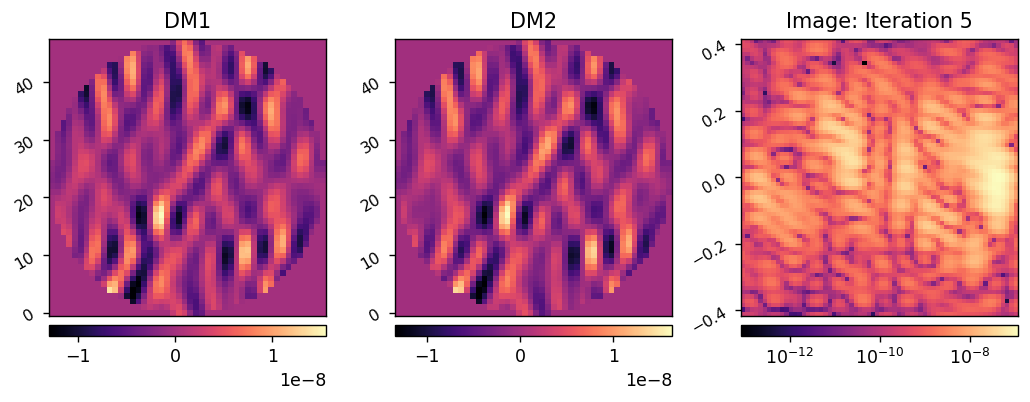

	Closed-loop iteration 6 / 20


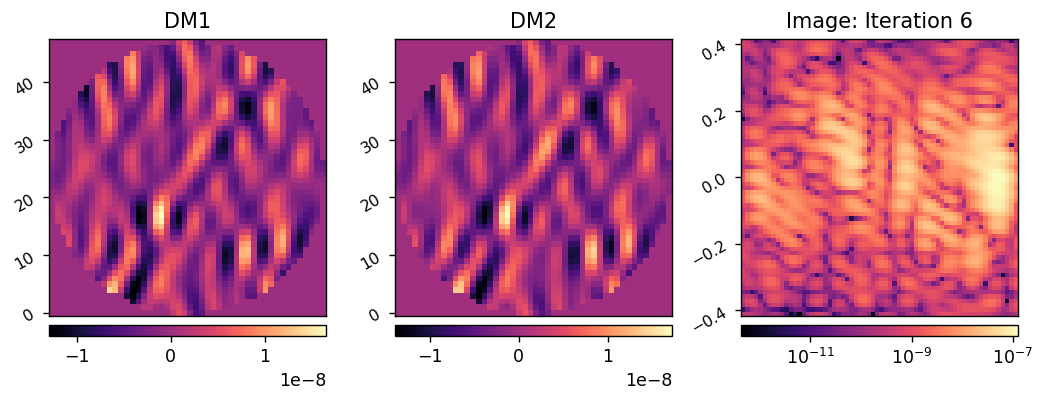

	Closed-loop iteration 7 / 20


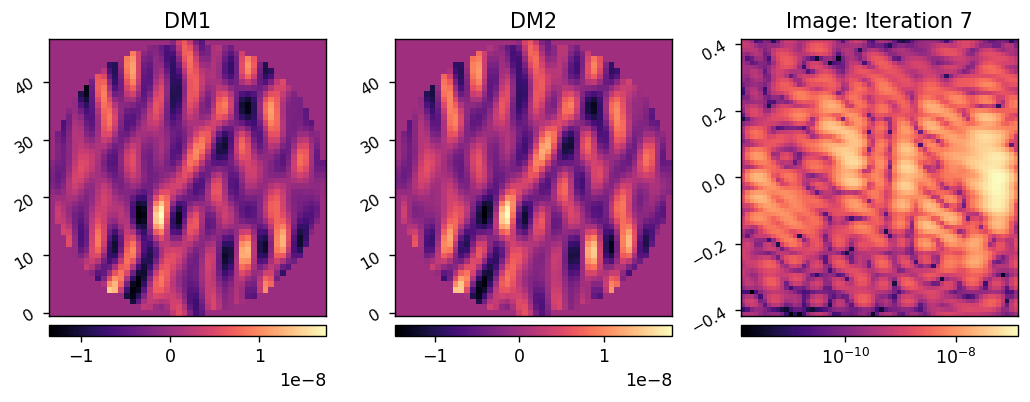

	Closed-loop iteration 8 / 20


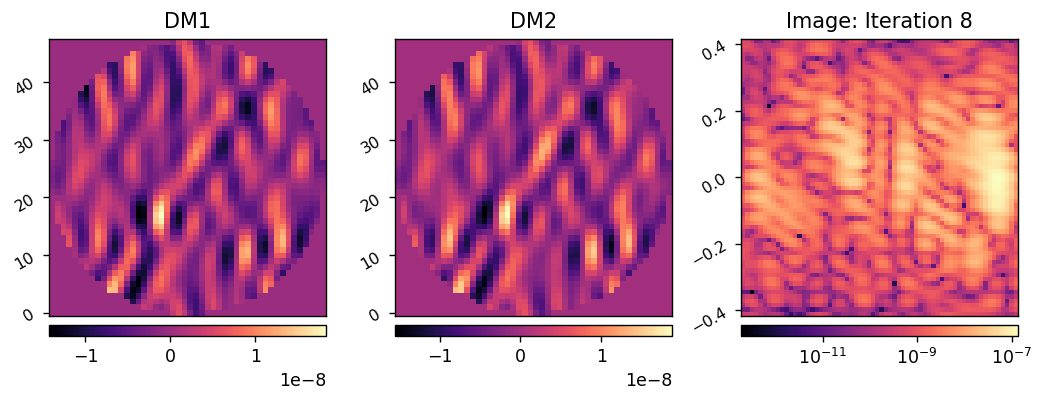

	Closed-loop iteration 9 / 20


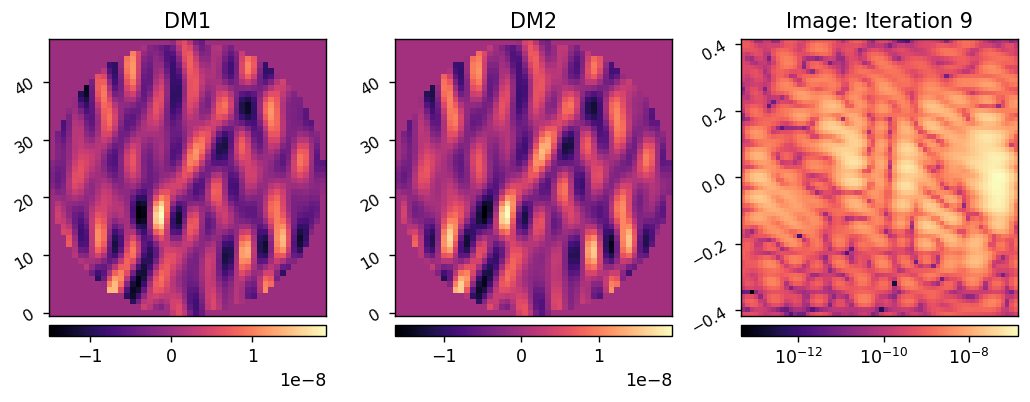

	Closed-loop iteration 10 / 20


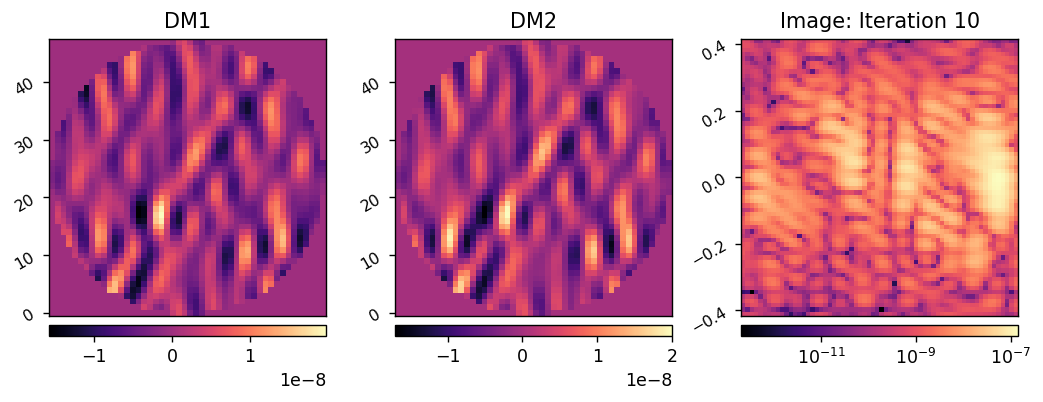

	Closed-loop iteration 11 / 20


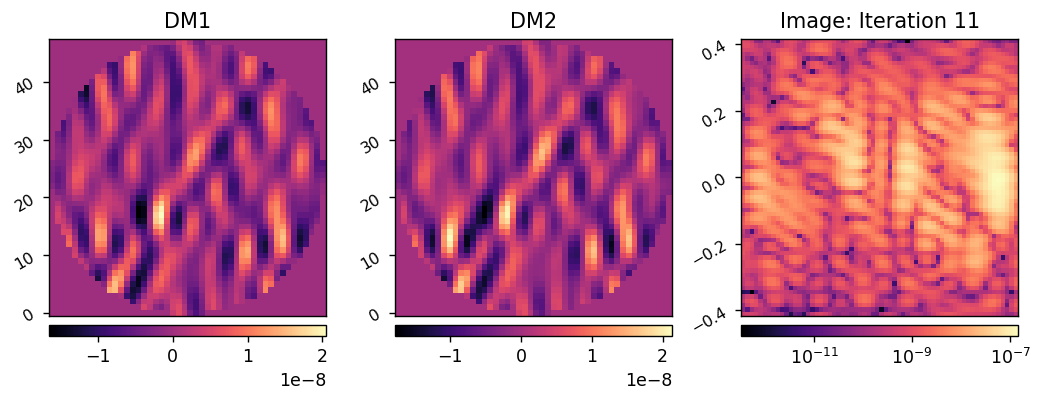

	Closed-loop iteration 12 / 20


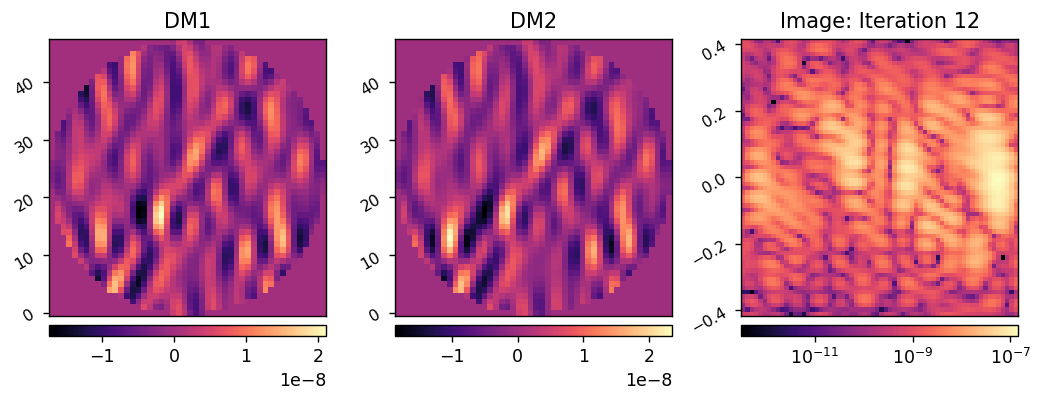

	Closed-loop iteration 13 / 20


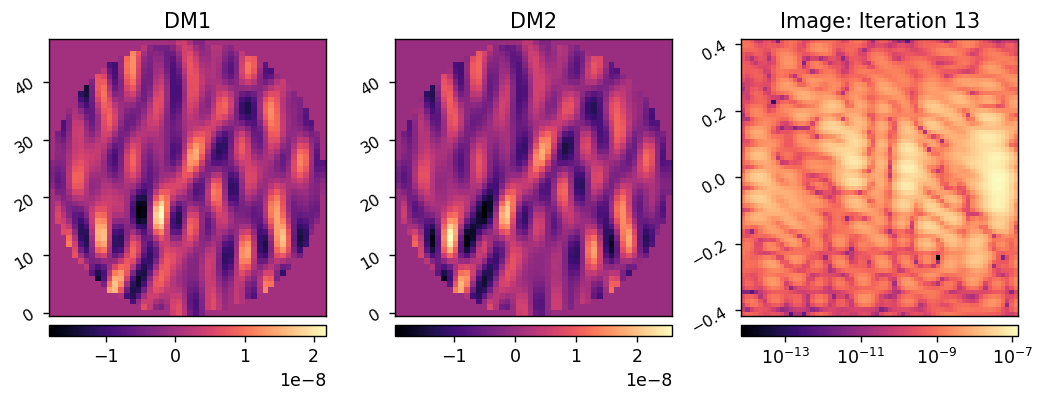

	Closed-loop iteration 14 / 20


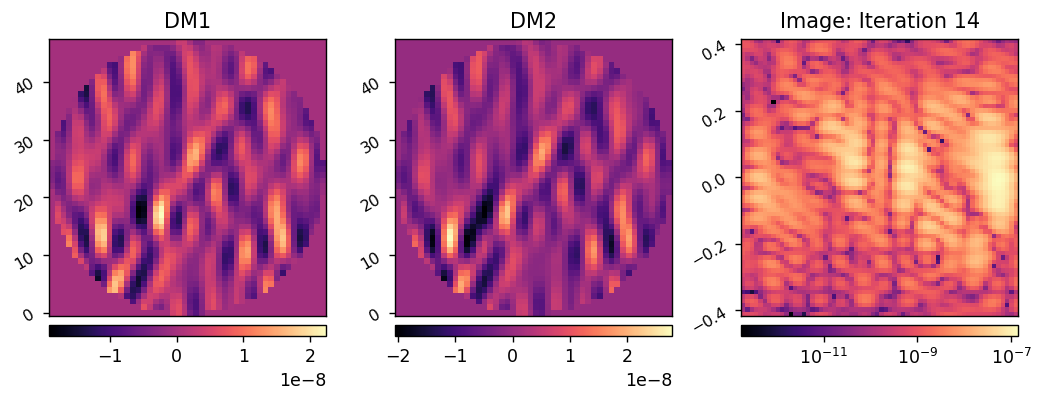

	Closed-loop iteration 15 / 20


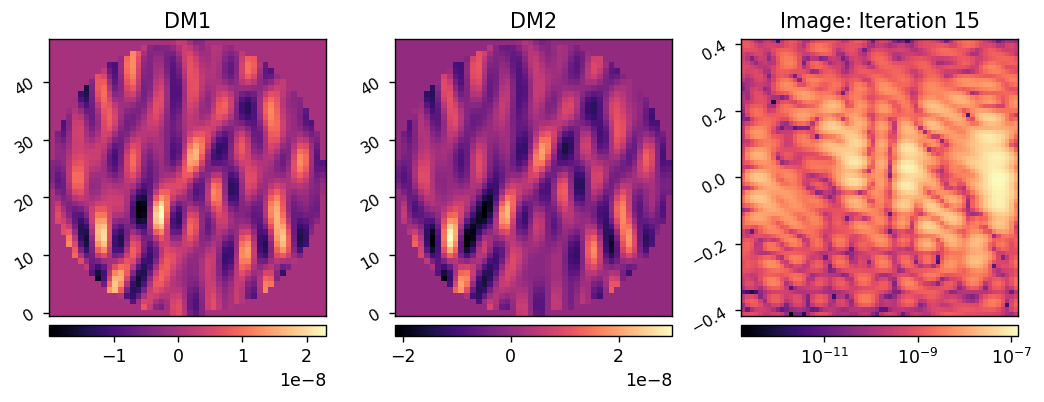

	Closed-loop iteration 16 / 20


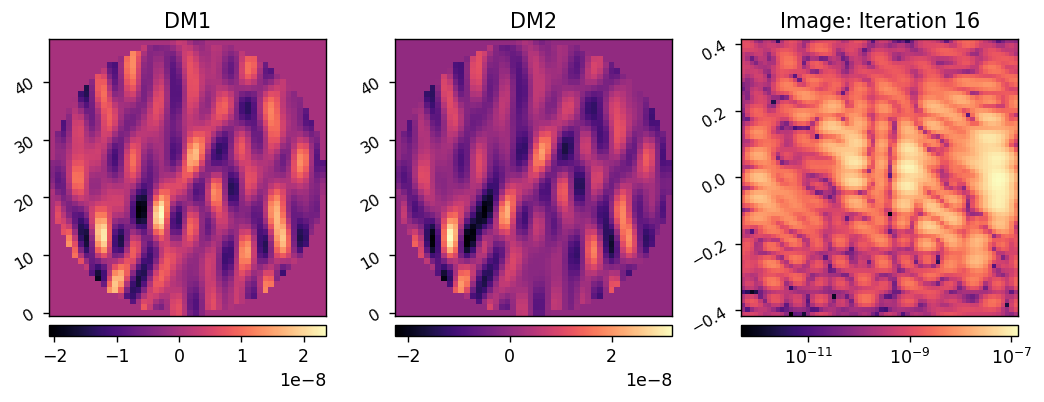

	Closed-loop iteration 17 / 20


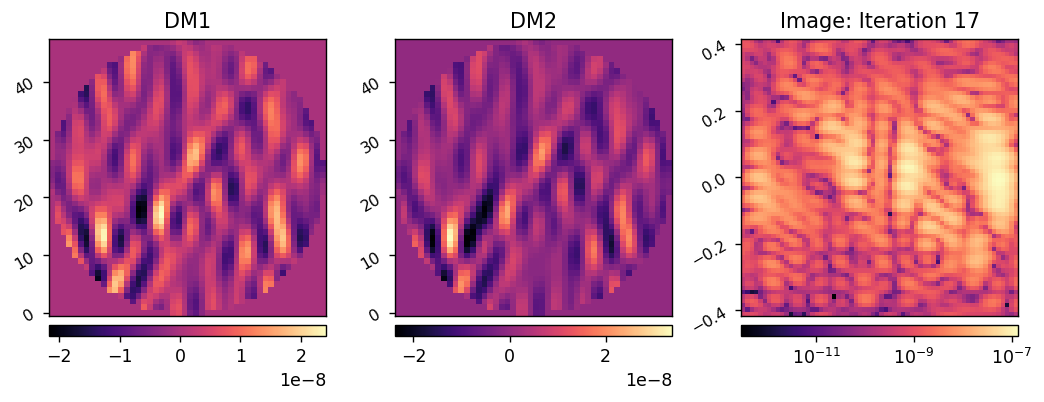

	Closed-loop iteration 18 / 20


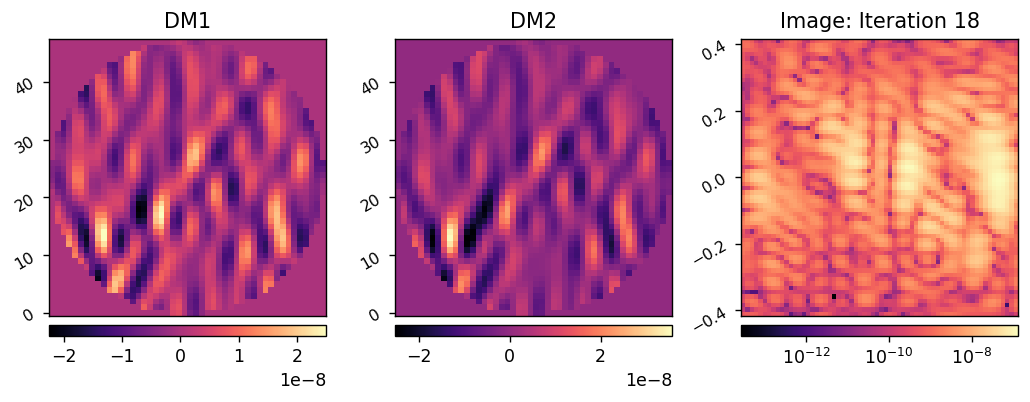

	Closed-loop iteration 19 / 20


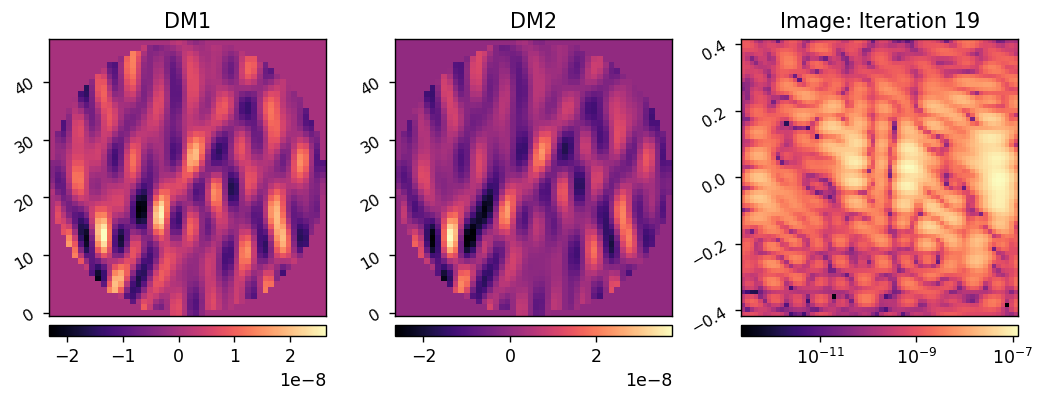

	Closed-loop iteration 20 / 20


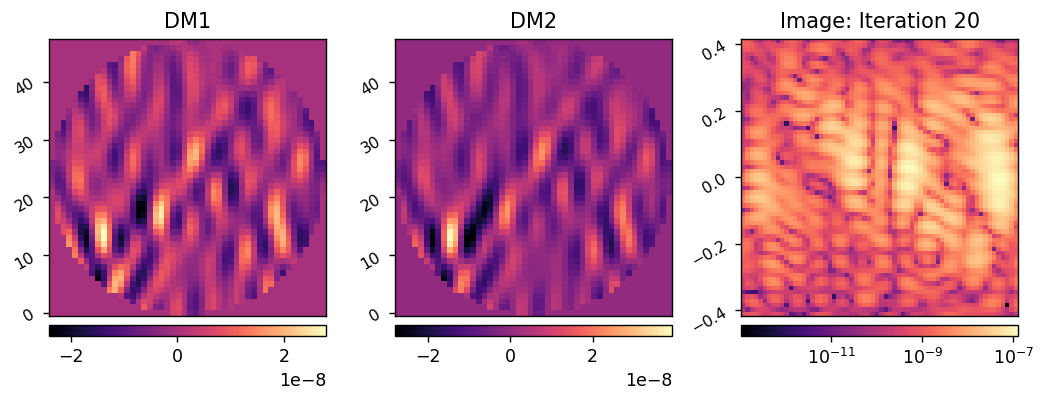

I-EFC loop completed in 44.072s.


In [11]:
reload(iefc)

sys.reset_dms()

images, dm1_commands, dm2_commands = iefc.run(sys, 
                                              control_matrix, 
                                              probe_modes, 
                                              probe_amplitude, 
                                              calibration_modes, 
                                              weights, 
                                              num_iterations=20, 
                                              gain=-0.5, leakage=0.0,
                                              display=True)

In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
